In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('GoEmotion_clean_data_simplified.csv')

In [3]:
df.head()

,text,main_emotion,cleaned_text
0,That game hurt.,sadness,game hurt
1,"You do right, if you don't care then fuck 'em!",neutral,right not care fuck
2,Man I love reddit.,joy,man love reddit
3,"[NAME] was nowhere near them, he was by the Fa...",neutral,nowhere near by falcon
4,Right? Considering it’s such an important docu...,joy,right considering important document know damn...


## Analyze the Vocabulary Distribution
Before deciding on max_features, analyze the word frequency distribution in your dataset to understand how many words carry meaningful information.

In [4]:
df['main_emotion'].isnull().value_counts()

main_emotion
False    46741
Name: count, dtype: int64

In [5]:
df['cleaned_text'].isnull().value_counts()

cleaned_text
False    46638
True       103
Name: count, dtype: int64

In [6]:
df = df.dropna()

In [7]:
print(f"Missing values in 'main_emotion': {df['main_emotion'].isna().sum()}")

Missing values in 'main_emotion': 0


In [8]:
print(f"Missing values in 'cleaned_text': {df['cleaned_text'].isna().sum()}")

Missing values in 'cleaned_text': 0


In [9]:
for text in df['cleaned_text'].sample(50):
    print(text)

would not get hope up dating
boycott gynolette
civil suit create legal precedence edit assuming civil suit
team arrow getting stalked sent threatening note also :( part
sorry not understand basic thrust socialism
cute little theory
wow story great art find more stuff like somewhere
why guy care much
no not
would love own deck like
incorrect taiwan regarded island no importance
believe only control speech held inside house representative not held place
thought didn see anything notable all
still need sleep go work tomorrow
agree congressional library excuse already fella try hit trim asap get asap
kpop stay legendary
look like brought nice variety try hope enjoyed
situation never ve gotten point
make time someone who make time full stop
priority apartment paperwork good luck
playing fire getting burned stay strong
thank much really really really nervous want cry
harris get money big retired
love sub people ;)
thanks warning :)
jersey great number
good console poor guy
eye witness always

In [10]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer()
word_count = count_vectorizer.fit_transform(df['cleaned_text'])

# Get word frequencies
word_freq = word_count.sum(axis=0).A1
vocab = count_vectorizer.get_feature_names_out()

# Create a DataFrame for analysis
word_freq_df = pd.DataFrame({'word': vocab, 'frequency': word_freq})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)
print(word_freq_df.head(10))  # View top 10 words


         word  frequency
14104     not       8587
12018    like       3610
22986    what       2846
23324   would       2547
8632      get       2231
535       all       2190
13991      no       2180
14471     one       2070
15215  people       1869
14656     out       1773


##  Feature Extraction Using TF-IDF

In [11]:
# Perform TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['cleaned_text']) # Use filtered dataframe

In [12]:
# Encode emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['main_emotion'])  # Use filtered dataframe

In [13]:
# Verify shapes
print("Shape of X:", X.shape)
print("Length of y:", len(y))

Shape of X: (46638, 10000)
Length of y: 46638


## Train-Test Split

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

## Optimizing hyperparameter

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Optimization solvers
    'max_iter': [500, 1000, 2000]  # Max iterations
}

In [16]:
# Create the model
logreg = LogisticRegression(class_weight='balanced', random_state=1)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',  # Optimize for macro-average F1-score
    verbose=2,
    n_jobs=-1  # Use all available processors
)

In [17]:
# Fit the model on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=1),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [500, 1000, 2000],
                         'solver': ['liblinear', 'saga']},
             scoring='f1_macro', verbose=2)

In [18]:
# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred))
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Best Hyperparameters: {'C': 1, 'max_iter': 500, 'solver': 'liblinear'}
Optimized Model Accuracy: 0.5700042881646655
Optimized Classification Report:
              precision    recall  f1-score   support

       anger       0.41      0.40      0.40      1247
        fear       0.24      0.36      0.29       203
         joy       0.72      0.60      0.65      2947
     neutral       0.61      0.65      0.63      4032
     sadness       0.37      0.39      0.38       714
    surprise       0.30      0.49      0.37       185

    accuracy                           0.57      9328
   macro avg       0.44      0.48      0.45      9328
weighted avg       0.58      0.57      0.57      9328



## Save Model and Vectorizer

In [19]:
# Save model and vectorizer
joblib.dump(best_model, 'text_classifier_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [20]:
# Load for prediction
loaded_model = joblib.load('text_classifier_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [21]:
# Predict on new text
new_text = ["hi"]
new_text_vectorized = loaded_vectorizer.transform(new_text)
prediction = loaded_model.predict(new_text_vectorized)
print("Predicted Emotion:", label_encoder.inverse_transform(prediction))

Predicted Emotion: ['neutral']


## Confusion Matrix

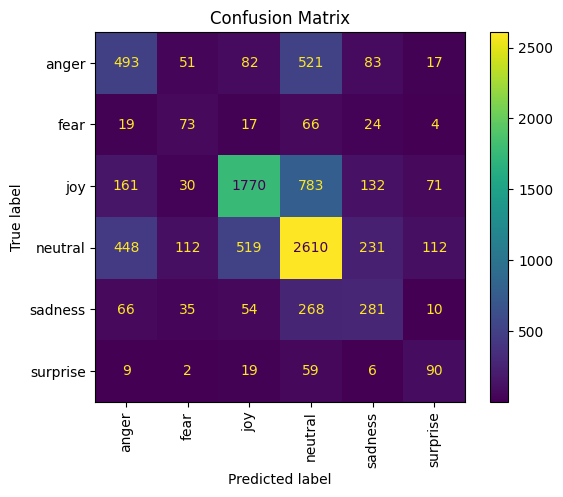

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


## Precision-Recall Curve

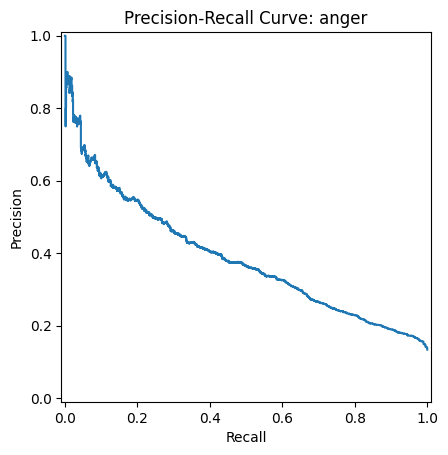

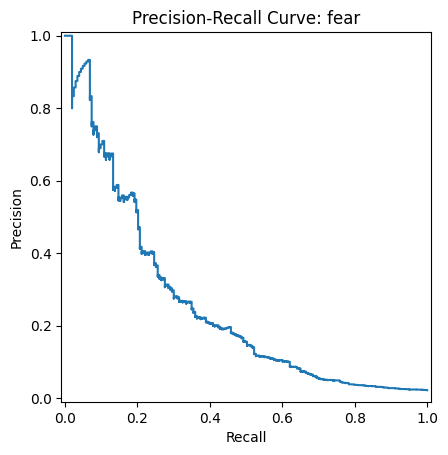

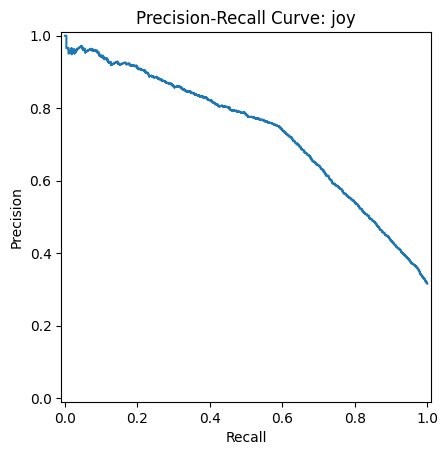

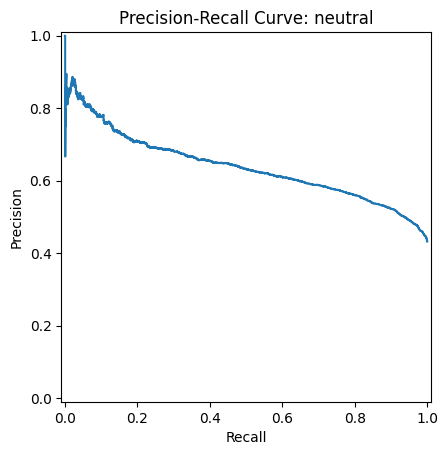

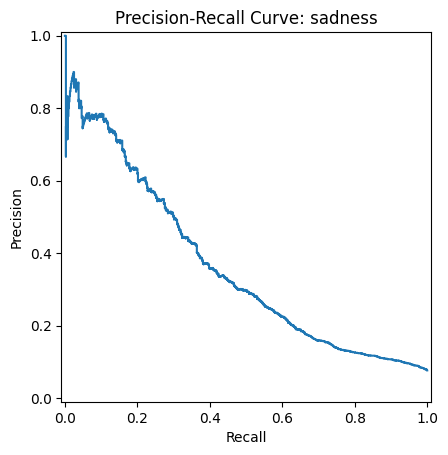

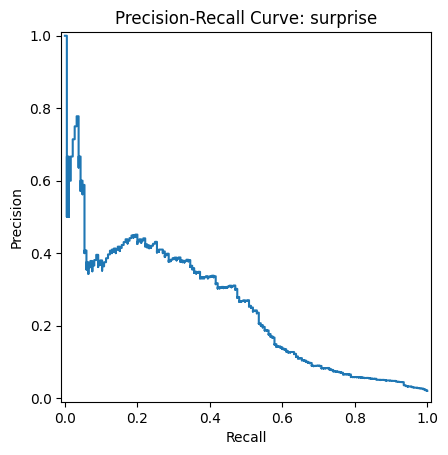

In [23]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Compute precision-recall curve for each class
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
y_pred_proba = best_model.predict_proba(X_test)

for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve: {class_name}')
    plt.show()

## Classification Report as a Heatmap

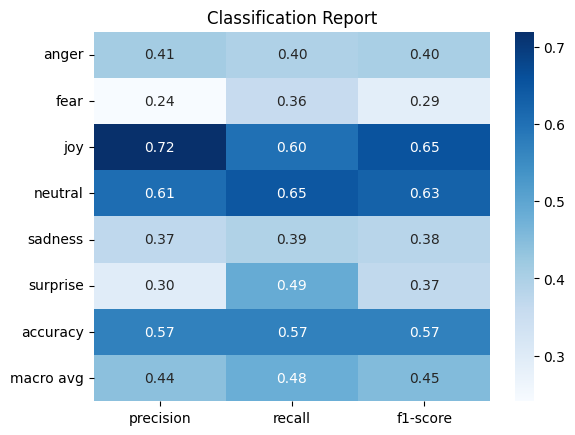

In [24]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot heatmap
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report')
plt.show()